# function text_detection_full_response

In [32]:
def text_detection_full_response(path):
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    return response

# function get_langauge

In [33]:
def get_language(response):
    language = response.text_annotations[0].locale
    print('language:')
    print(language)
    print()
    return language

# function strip_menu

In [144]:
def strip_menu(response):
    import pandas as pd
    
    # remove these chars from entry
    chars_to_remove = pd.read_csv('../data/chars_to_remove.csv')
    chars_to_remove = chars_to_remove['name'].tolist()

    # remove entry if it exactly matches any of these (words or phrases)
    drop_exact_words = pd.read_csv('../data/drop_exact.csv')
    drop_exact_words = drop_exact_words['name'].tolist()
    drop_exact_words = [item.lower() for item in drop_exact_words]


    # remove these words from entry (words only)
    words_to_remove = pd.read_csv('../data/words_to_remove.csv')
    words_to_remove = words_to_remove['name'].tolist()
    
    # remove entry if it contains any of these (words or phrases)
    drop_contain_words = pd.read_csv('../data/drop_contain.csv')
    drop_contain_words = drop_contain_words['name'].tolist()

    
    # remove entry if it starts with any of these (words or phrases)
    drop_start_words = pd.read_csv('../data/drop_start.csv')
    drop_start_words = drop_start_words['name'].tolist()
    
    # drop entry if it contains fewer chars than minimum
    min_length = 4
    
    text = response.text_annotations[0].description
    menu_original = text.lower()
    menu_original = menu_original.split('\n')
    
    menu_chars_removed = []
    for item in menu_original:
        for char in chars_to_remove:
            item = item.replace(char,' ')
        menu_chars_removed.append(item)
    menu_chars_removed = [item.strip() for item in menu_chars_removed]
      
    menu_exact_matches_dropped = []
    for item in menu_chars_removed:
        if item.lower() in drop_exact_words:
            pass
        else:
            menu_exact_matches_dropped.append(item)
        
    menu_words_removed = []
    for item in menu_exact_matches_dropped:
        temporary = []
        for word in item.split(' '):
            if word.lower() not in words_to_remove:
                temporary.append(word)
        remaining_words = ' '.join(temporary)
        menu_words_removed.append(remaining_words)
               
             
    menu_contains_dropped = []
    dropping = []
    for item in menu_words_removed:
        for i in drop_contain_words:
            if i in item:
                dropping.append(item)
    for item in menu_words_removed:
        if item not in dropping:
            menu_contains_dropped.append(item)

    menu_starts_dropped = []
    dropping = []
    for item in menu_contains_dropped:
        for i in drop_start_words:
            if item.startswith(i):
                dropping.append(item)
    for item in menu_contains_dropped:
        if item not in dropping:
            menu_starts_dropped.append(item)

    
    menu_exact_matches_dropped = []
    for item in menu_starts_dropped:
        if item.lower() in drop_exact_words:
            pass
        else:
            menu_exact_matches_dropped.append(item)
            
    bounding_white_space_removed = [item.strip() for item in menu_exact_matches_dropped]
    too_short_dropped = [item for item in bounding_white_space_removed if len(item) >= min_length]
    
    duplicates_dropped = []
    for item in too_short_dropped:
        if item not in duplicates_dropped:
            duplicates_dropped.append(item)

    
    stripped_menu = duplicates_dropped
    
    print('original menu:')
    print()
    print(menu_original)
    print()
    print('stripped menu:')
    print()
    print(stripped_menu)
    print()
    return(stripped_menu)

# function optimized_image_fetch_and_check


In [152]:
def optimized_image_fetch_and_check(query):
    import os
    from dotenv import load_dotenv, find_dotenv
    from google_images_search import GoogleImagesSearch
    from google.cloud import vision
    import pandas as pd

    env_path = find_dotenv()
    load_dotenv(env_path)
    
    GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
    GOOGLE_CX = os.getenv('GOOGLE_CX')
    
    helper_word = 'recipe'
    
    bev_cv = pd.read_csv('../data/stripped_drinks.csv')
    beverages = bev_cv['name'].tolist()

    if query.lower() in beverages:
        helper_word = 'beverage'
    
    print(f'searching for {query} ({helper_word})...')
    print()

    gis = GoogleImagesSearch(GOOGLE_API_KEY,GOOGLE_CX)

    if query.lower() in beverages:
        helper_word = 'beverage'
    
    _search_params = {
    'q': f'{query} {helper_word}',
    'num': 1,
    #'imgSize': 'large',
    'imgType': 'photo',
    'imgColorType': 'color'}
    
    gis.search(search_params=_search_params)
    print('fetching image:')
    if len(gis.results()) == 0:
        print('no image found, not verified as food.')
        print()
        return None
    
    url = gis.results()[0].url
    print(url)
    print()
    
    verified_queries = pd.read_csv('../data/verified.csv')
    verified_queries = verified_queries['name'].tolist()

    if query.lower() in verified_queries:
        print(f'{query} already in known foods database, no need to verify!')
        print()
        return url
    
    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = url
    
    response = client.label_detection(image=image, max_results=1)
    label = [lab.description for lab in response.label_annotations]
    score = [lab.score for lab in response.label_annotations]
    
    text_response = client.text_detection(image=image)
    texts = text_response.text_annotations
    n_chars = 0
    if len(texts)>0:
        n_chars = len(texts[0].description)
    
    print('verification filter:')
    print('label must be Food, Tableware, Bottle, Beverage can, Liquid, or Water')
    print('score must be above .955')
    print('number of chars must be below 200')
    print()
    print(f'label: {label}')
    print(f'label score: {score}')
    print(f'chars detected: {n_chars}')
    print()
    
    try:
        if (label[0] in ['Food','Tableware','Bottle','Beverage can','Liquid','Water']) and score[0] > .955 and n_chars < 200:
            print('verified!')
            print()
            print(url)
            print()
            return url
    except IndexError:
        print('label missing, not verified.')
        pass
    

    _search_params = {
    'q': f'{query} {helper_word}]',
    'num': 3,
    #'imgSize': 'large',
    'imgType': 'photo',
    'imgColorType': 'color',
    'safe': 'medium'}
        
    gis = GoogleImagesSearch(GOOGLE_API_KEY,GOOGLE_CX)
    gis.search(search_params=_search_params)
    urls = [result.url for result in gis.results()]
    print('fetching additional images:')
    if len(urls)<=1:
        print('no additional images found, not verified.')
        return None
    urls = urls[1:]
    for url in urls:
        print(url)
    print()
    
    labels = []
    scores = []
    char_counts = [] 
    for url in urls:
        
        image.source.image_uri = url
        response = client.label_detection(image=image, max_results=1)
        label = [lab.description for lab in response.label_annotations]
        score = [lab.score for lab in response.label_annotations]
        labels.append(label)
        scores.append(score)
        
        text_response = client.text_detection(image=image)
        texts = text_response.text_annotations
        n_chars = 0
        if len(texts)>0:
            n_chars = len(texts[0].description)
        char_counts.append(n_chars)
        
    print(f'labels: {labels}')
    print(f'label scores: {scores}')
    print(f'chars detected: {char_counts}')
    print()

    for label,score,n_chars in zip(labels,scores, char_counts):
        try:
            if (label[0] in ['Food','Tableware','Bottle','Beverage can','Liquid','Water']) and score[0] > .955 and n_chars < 200:
                print('verified!')
                print()
                print(urls[labels.index(label)])
                print()
                return urls[labels.index(label)]
        except:
            pass
        
    print('not verified.')
    print()
    return None

# tuning the stripper/checker

In [153]:
response = text_detection_full_response('../raw_data/all_menus/slack-imgs.jpg')

In [156]:
stripped_menu = strip_menu(response)

original menu:

['menu', '"ooftop', 'main course', 'grill chicken sandwich... 40k', '(two slice toast, frill chicken, ice berg, tomato slice,', 'mozzarella cheese serve with french fries and chili', 'tomato sauce)', '.....50k', 'beef burger.........', '(white bun, beef patty, lettuce, tomato, cheese,', 'bbq sauce, pork bacon, and french fries)', '......30k', 'singapore fried noodle..........', '(stir fry noodle with veggie, chicken satay, and', 'fried egg on top and crackers)', 'fried rice.....', '(stir fry rice with veggie, chicken satay, and fried', 'egg on top with crackers)', 'ayam bakar taliwang........', '(grill chicken leg serve with sayur kalasan, rice,', 'and balinese sauce)', 'chicken satay.........', '(grill chicken satay serve with rice, crackers,', 'and peanut sauce)', 'seaduction', 'bar', '......30k', '.....30k', '....30k', '(4']

stripped menu:

['grill chicken sandwich', 'beef burger', 'singapore fried noodle', 'fried rice', 'ayam bakar taliwang', 'chicken satay']



In [157]:
for item in stripped_menu:
    optimized_image_fetch_and_check(item)

searching for grill chicken sandwich (recipe)...

fetching image:
https://www.askchefdennis.com/wp-content/uploads/2020/05/ultimate-grilled-chicken-sandwich-10.jpg

grill chicken sandwich already in known foods database, no need to verify!

searching for beef burger (recipe)...

fetching image:
https://food.fnr.sndimg.com/content/dam/images/food/fullset/2011/5/4/0/FNM_060111-Perfect-Patties-002_s4x3.jpg.rend.hgtvcom.616.462.suffix/1371597603943.jpeg

beef burger already in known foods database, no need to verify!

searching for singapore fried noodle (recipe)...

fetching image:
https://www.seriouseats.com/thmb/Q3LbIBiUQXAhBSP-dvJXmzS5kMU=/1500x1125/filters:fill(auto,1)/__opt__aboutcom__coeus__resources__content_migration__serious_eats__seriouseats.com__recipes__images__2015__05__20150424-singapore-noodles-shao-zhong-20-130b0ed9d8ad45b3bd164cbe1328abef.jpg

singapore fried noodle already in known foods database, no need to verify!

searching for fried rice (recipe)...

fetching image:


# function detect_text_points

In [55]:
def detect_text_points(response):
    
    import pandas as pd
    import string
    
    chars_to_remove = '0123456789!"\'#$%&()*+,-./:;<=>?@[\]^_`{|}~♦●★‒…£¡™¢∞§¶•ªº–≠≠œ∑´®†¥¨≤≥÷ç√€。'
    
    texts = response.text_annotations
    language = texts[0].locale

    text_list = []
    location_list = []

    for text in texts[1:]:
        new_text = '''{}'''.format(text.description)
        text_list.append(new_text)
        
        vertices = [tuple((vertex.x, vertex.y)) for vertex in text.bounding_poly.vertices]
        
        location_list.append(vertices[0])
        
    detected_df = pd.DataFrame({
        'text': text_list,
        'location': location_list})

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    
    if language in ['zh','zh-hk','zh-cn','zh-sg','zh-tw','ja','ko']:
        split_chars = []
        for item in detected_df.text:
            split_chars.append([char for char in item])
        
        detected_df['text'] = split_chars
        detected_df = detected_df.explode('text')
    
    for char in chars_to_remove:
        detected_df = detected_df[detected_df['text'] != char]
    
    detected_df['text'] = detected_df['text'].str.lower()
    print(detected_df)
    print()

        
    return detected_df

#  (old) function detect_text_boxes

In [ ]:
def detect_text_boxes(response):
    
    import pandas as pd
    
    texts = response.text_annotations
    language = texts[0].locale

    text_list = []
    top_left = []
    top_right = []
    bottom_left = []
    bottom_right = []


    for text in texts[1:]:
        new_text = '''{}'''.format(text.description)
        text_list.append(new_text)
        
        vertices = [tuple((vertex.x, vertex.y)) for vertex in text.bounding_poly.vertices]

        new_bounding = vertices

        top_left.append(vertices[0])
        top_right.append(vertices[1])
        bottom_left.append(vertices[3])
        bottom_right.append(vertices[2])
        
    detected_df = pd.DataFrame({
        'text': text_list,
        'top_left': top_left,
        'top_right': top_right,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right
    })

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    
    if language in ['zh','zh-hk','zh-cn','zh-sg','zh-tw','ja','ko']:
        split_chars = []
        for item in detected_df.text:
            split_chars.append([char for char in item])
        
        detected_df['text'] = split_chars
        detected_df = detected_df.explode('text')
    
    print(detected_df)
    print()
        
    return detected_df


#  (old) function map_text_boxes

In [ ]:
def map_text_boxes(detected_df, stripped_menu, language='en'):
    from itertools import combinations
    import pandas as pd
    from statistics import stdev
    import string

    test_menu_df = detected_df
    
    if language in ['ar','iw','fa','ur','sd','ps','yi']:
        box_dict = dict()
        for item in stripped_menu:
            box_dict[item] = None
        print(box_dict)
        print()
        return box_dict
    
    if language in ['zh','zh-hk','zh-cn','zh-sg','zh-tw','ja','ko'] and len(detected_df)>225:
        box_dict = dict()
        for item in stripped_menu:
            box_dict[item] = None
        print(box_dict)
        print()
        return box_dict

    split_keys = []
    if language in ['zh','zh-hk','zh-cn','zh-sg','zh-tw','ja','ko']:
        for item in stripped_menu:
            split_keys.append([char for char in item])
            
    else:
        for item in stripped_menu:
            split_keys.append(item.split())

    temp_dfs = []
    for key_set in split_keys:
        temp_df = pd.DataFrame()
        for key in key_set:
            mask = test_menu_df['text'] == key
            temp_df = pd.concat([temp_df, test_menu_df[mask]])
            temp_df = temp_df.drop_duplicates()
        temp_df['position'] = temp_df['bottom_left'] 

        word_positions = list(zip(temp_df.text, temp_df.position))
        combos = []

        for combo in list(combinations(word_positions, len(key_set))): 
            text_portion = [pair[0] for pair in combo]
            if len(set(text_portion)) == len(key_set):
                combos.append(combo)
        calc_df = pd.DataFrame(combos)

        position_stds = []
        for combo in combos:
            position = [pair[1] for pair in combo]
            if len(position) >= 2:
                calc_nums = [pair[1] for pair in position]
                position_stds.append(stdev(calc_nums))
            else:
                position_stds.append(0)
        calc_df['position_stds'] = position_stds
        calc_df = calc_df.sort_values(by=['position_stds'])

        if len(calc_df) > 0:
            calc_df = calc_df.iloc[[0]]

        keep = []
        keep_text = []
        keep_pos = []
        for column in calc_df:
            if column != 'position_stds':
                keep.append(calc_df[column].to_string(index=False))
        for item in keep:
            pair = item.split(', ')
            temp_text = [char for char in pair[0] if char not in '[](),']
            temp_pos = [char for char in pair[1:]]
            temp_pos = str(temp_pos)
            temp_pos = [char for char in temp_pos if char in string.digits or char not in string.punctuation]
            temp_text = ''.join(temp_text)
            temp_pos = ''.join(temp_pos)
            temp_pos = temp_pos.split(' ')
            temp_pos = [int(n) for n in temp_pos]
            temp_pos = tuple(temp_pos)

            keep_text.append(''.join(temp_text))
            keep_pos.append(temp_pos)

        merge_df = pd.DataFrame()
        for text,pos in zip(keep_text,keep_pos):
            merge_df = pd.concat([merge_df, pd.DataFrame({'text': [text],
                                    'top_left': [None],
                                    'top_right': [None],
                                    'bottom_left': [None],
                                    'bottom_right': [None],
                                    'position': [pos]})], ignore_index=False)
        temp_df = pd.concat([temp_df,merge_df],ignore_index=False)
        if None in temp_df['top_left'].values:
            temp_df = temp_df.loc[temp_df.duplicated(subset='position', keep=False)]
        temp_df = temp_df.dropna()

        for index in temp_df.index:
            if index in test_menu_df.index:
                test_menu_df = test_menu_df.drop(index)
        temp_dfs.append(temp_df)
        
    box_dict = {}

    for i, item in enumerate(stripped_menu):
        try:
            box_dict[item] = [temp_dfs[i].iloc[0]['top_left'],
                     temp_dfs[i].iloc[-1]['bottom_right']]
        except IndexError:
            box_dict[item] = None 
    
    print(box_dict)
    return box_dict

# function detect_item_locations

In [48]:
def detect_item_locations(detected_df, stripped_menu, language='en'):
    from itertools import combinations
    import pandas as pd
    from statistics import stdev
    import string
    
    if language in ['ar','iw','fa','ur','sd','ps','yi']:
        box_dict = dict()
        for item in stripped_menu:
            box_dict[item] = None
        print(box_dict)
        print()
        return box_dict
    
    if language in ['zh','zh-hk','zh-cn','zh-sg','zh-tw','ja','ko'] and len(detected_df)>110:
        box_dict = dict()
        for item in stripped_menu:
            box_dict[item] = None
        print(box_dict)
        print()
        return box_dict

    split_items = []
    if language in ['zh','zh-hk','zh-cn','zh-sg','zh-tw','ja','ko']:
        for item in stripped_menu:
            split_items.append([char for char in item])
            
    else:
        for item in stripped_menu:
            split_items = [item.split() for item in stripped_menu]
    

    final_item_locations = dict()
    all_items_dfs = []
    for item in split_items:
        item_df = pd.DataFrame()
        for word in item:
            mask = detected_df['text'] == word
            item_df = pd.concat([item_df, detected_df[mask]])
            item_df = item_df.drop_duplicates()
        all_items_dfs.append(item_df)
        
        word_locations = list(zip(item_df.text, item_df.location))
        
        combos = []
        
        for combo in list(combinations(word_locations, len(item))):
            word = [pair[0] for pair in combo]
            if len(set(word)) == len(item):
                combos.append(combo)
                
        calc_df = pd.DataFrame(combos)
      
        location_stds =  []
        for combo in combos:
            location = [pair[1] for pair in combo]

            if len(location) >=2:
                calc_nums = [pair[1] for pair in location]
                location_stds.append(stdev(calc_nums))
            else:
                location_stds.append(0)
        calc_df['location_stds'] = location_stds
        calc_df = calc_df.sort_values(by=['location_stds'])
        
        if len(calc_df) > 0:
            calc_df = calc_df.iloc[[0]]
        
        item_full_info = []
        for column in calc_df:
            if column != 'location_stds':
                item_full_info.append(calc_df[column].to_string(index=False))

        item_name = []
        item_location = []
        for item in item_full_info:
            pair = item.split(', ')
            
            name = [char for char in pair[0] if char not in '[](),']
            name = ''.join(name)
            item_name.append(''.join(name))
            
            location = [char for char in pair [1:]]
            location = str(location)
            location = [char for char in location if char in string.digits or char not in string.punctuation]
            location = ''.join(location)
            location = location.split(' ')
            location = [int(n) for n in location]
            item_location.append(location)
            
        item_name = ' '.join(item_name)
        if len(item_location) > 0:
            final_item_locations[item_name] = item_location[0]
            
    for item_name in stripped_menu:
        if item_name not in final_item_locations.keys():
            final_item_locations[item_name] = None
        
    print(final_item_locations)
    return final_item_locations

# function show_menu_markers

In [49]:
def show_menu_markers(path, coord_dict):
    import io
    from matplotlib import pyplot as plt
    #from matplotlib import patches as pch
    
    
    a = plt.imread(path)
    fig, ax = plt.subplots(1)
    ax.imshow(a)
    
    for value in coord_dict.values():
        ax.scatter(x = value[0], y =value[1], alpha=.66, marker ="*", c='red', edgecolors='blue', s=100)
        

#  testing it out

In [158]:
# back end
path = '../raw_data/all_menus/slack-imgs.jpg'
response = text_detection_full_response(path)
language = get_language(response)
stripped_menu = strip_menu(response)
detected_df = detect_text_points(response)

language:
en

original menu:

['menu', '"ooftop', 'main course', 'grill chicken sandwich... 40k', '(two slice toast, frill chicken, ice berg, tomato slice,', 'mozzarella cheese serve with french fries and chili', 'tomato sauce)', '.....50k', 'beef burger.........', '(white bun, beef patty, lettuce, tomato, cheese,', 'bbq sauce, pork bacon, and french fries)', '......30k', 'singapore fried noodle..........', '(stir fry noodle with veggie, chicken satay, and', 'fried egg on top and crackers)', 'fried rice.....', '(stir fry rice with veggie, chicken satay, and fried', 'egg on top with crackers)', 'ayam bakar taliwang........', '(grill chicken leg serve with sayur kalasan, rice,', 'and balinese sauce)', 'chicken satay.........', '(grill chicken satay serve with rice, crackers,', 'and peanut sauce)', 'seaduction', 'bar', '......30k', '.....30k', '....30k', '(4']

stripped menu:

['grill chicken sandwich', 'beef burger', 'singapore fried noodle', 'fried rice', 'ayam bakar taliwang', 'chicken

In [159]:
final_item_locations = detect_item_locations(detected_df, stripped_menu, language)

{'grill chicken sandwich': [346, 1146], 'beef burger': [320, 1640], 'singapore fried noodle': [300, 2089], 'fried rice': [274, 2524], 'ayam bakar taliwang': [249, 2936], 'chicken satay': [1317, 2247]}


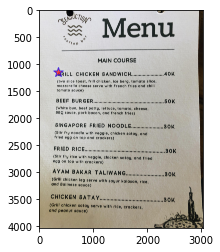

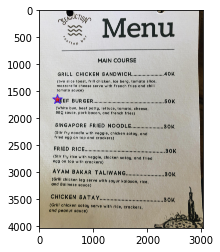

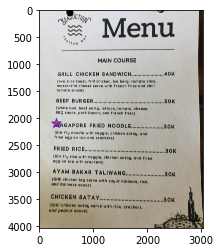

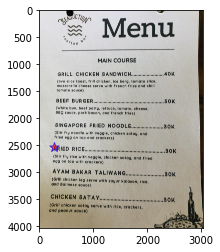

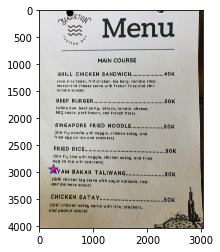

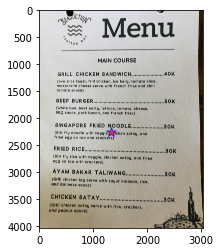

In [161]:
path = '../raw_data/all_menus/slack-imgs.jpg'
for key,value in final_item_locations.items():
    if value !=None:
        coord_dict = {key:value}
        show_menu_markers(path, coord_dict)